# NFL Competition

# Feature Engineering e Modelo de Machine Learning

## 1. Importa os pacotes e o dataset de treino

In [1]:
# Importar os principais pacotes
import numpy as np
import pandas as pd
import sklearn.metrics as mtr
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
import re
import codecs
import time
import datetime
import tsfresh
import pandasql as ps

# Evitar que aparece os warnings
import warnings
warnings.filterwarnings("ignore")

# Seta algumas opções no Jupyter para exibição dos datasets
pd.set_option('display.max_columns', 150)
pd.set_option('display.max_rows', 150)

In [2]:
# Importa os pacotes de algoritmos de regressão
from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgb
from lightgbm import LGBMRegressor

# Importa os pacotes de algoritmos de redes neurais (Keras)
from keras.losses import binary_crossentropy
from keras.utils import to_categorical
from keras.layers import Dense,Input,Flatten,concatenate,Dropout,Lambda,BatchNormalization
from keras.models import Sequential, Model
from keras.callbacks import Callback,EarlyStopping,ModelCheckpoint
import keras.backend as K
#from keras_lookahead import Lookahead
#from keras_radam import RAdam

# Importa pacotes do sklearn
from sklearn import preprocessing
from sklearn.model_selection import KFold, train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.preprocessing import scale, MinMaxScaler, StandardScaler

Using TensorFlow backend.


In [3]:
# Define o caminho do arquivo
path_local  = '../data/train.csv'
path_kernel = '/kaggle/input/nfl-big-data-bowl-2020/train.csv'

# Carrega o dataset de treino
train = pd.read_csv(path_local, usecols =['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis',
                                          'Orientation', 'Dir', 'NflId', 'DisplayName', 'YardLine',
                                          'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
                                          'FieldPosition', 'NflIdRusher', 'OffenseFormation', 
                                          'OffensePersonnel', 'DefendersInTheBox', 'DefensePersonnel', 
                                          'PlayDirection', 'TimeHandoff', 'TimeSnap', 'HomeTeamAbbr','VisitorTeamAbbr',
                                          'PlayerHeight','WindSpeed','PlayerBirthDate','Season','Yards'])

# Usado somente para teste (somente as primeiras 2200 linhas)
#train = train[:2200]

## 2. Feature Engineering

In [4]:
def create_features_01(df, deploy=False):
    def new_X(x_coordinate, play_direction):
        if play_direction == 'left':
            return 120.0 - x_coordinate
        else:
            return x_coordinate

    def new_line(rush_team, field_position, yardline):
        if rush_team == field_position:
            # offense starting at X = 0 plus the 10 yard endzone plus the line of scrimmage
            return 10.0 + yardline
        else:
            # half the field plus the yards between midfield and the line of scrimmage
            return 60.0 + (50 - yardline)

    def new_orientation(angle, play_direction):
        if play_direction == 'left':
            new_angle = 360.0 - angle
            if new_angle == 360.0:
                new_angle = 0.0
            return new_angle
        else:
            return angle

    def euclidean_distance(x1,y1,x2,y2):
        x_diff = (x1-x2)**2
        y_diff = (y1-y2)**2

        return np.sqrt(x_diff + y_diff)

    def back_direction(orientation):
        if orientation > 180.0:
            return 1
        else:
            return 0

    def update_yardline(df):
        new_yardline = df[df['NflId'] == df['NflIdRusher']]
        new_yardline['YardLine'] = new_yardline[['PossessionTeam','FieldPosition','YardLine']].apply(lambda x: new_line(x[0],x[1],x[2]), axis=1)
        new_yardline = new_yardline[['GameId','PlayId','YardLine']]

        return new_yardline

    def update_orientation(df, yardline):
        df['X'] = df[['X','PlayDirection']].apply(lambda x: new_X(x[0],x[1]), axis=1)
        df['Orientation'] = df[['Orientation','PlayDirection']].apply(lambda x: new_orientation(x[0],x[1]), axis=1)
        df['Dir'] = df[['Dir','PlayDirection']].apply(lambda x: new_orientation(x[0],x[1]), axis=1)

        df = df.drop('YardLine', axis=1)
        df = pd.merge(df, yardline, on=['GameId','PlayId'], how='inner')

        return df

    def back_features(df):
        carriers = df[df['NflId'] == df['NflIdRusher']][['GameId','PlayId','NflIdRusher','X','Y','Orientation','Dir','YardLine']]
        carriers['back_from_scrimmage'] = carriers['YardLine'] - carriers['X']
        carriers['back_oriented_down_field'] = carriers['Orientation'].apply(lambda x: back_direction(x))
        carriers['back_moving_down_field'] = carriers['Dir'].apply(lambda x: back_direction(x))
        carriers = carriers.rename(columns={'X':'back_X',
                                            'Y':'back_Y'})
        carriers = carriers[['GameId','PlayId','NflIdRusher','back_X','back_Y','back_from_scrimmage','back_oriented_down_field','back_moving_down_field']]

        return carriers

    def features_relative_to_back(df, carriers):
        player_distance = df[['GameId','PlayId','NflId','X','Y']]
        player_distance = pd.merge(player_distance, carriers, on=['GameId','PlayId'], how='inner')
        player_distance = player_distance[player_distance['NflId'] != player_distance['NflIdRusher']]
        player_distance['dist_to_back'] = player_distance[['X','Y','back_X','back_Y']].apply(lambda x: euclidean_distance(x[0],x[1],x[2],x[3]), axis=1)

        player_distance = player_distance.groupby(['GameId','PlayId','back_from_scrimmage','back_oriented_down_field','back_moving_down_field'])\
                                         .agg({'dist_to_back':['min','max','mean','std']})\
                                         .reset_index()
        player_distance.columns = ['GameId','PlayId','back_from_scrimmage','back_oriented_down_field','back_moving_down_field',
                                   'min_dist','max_dist','mean_dist','std_dist']

        return player_distance

    def defense_features(df):
        rusher = df[df['NflId'] == df['NflIdRusher']][['GameId','PlayId','Team','X','Y']]
        rusher.columns = ['GameId','PlayId','RusherTeam','RusherX','RusherY']

        defense = pd.merge(df,rusher,on=['GameId','PlayId'],how='inner')
        defense = defense[defense['Team'] != defense['RusherTeam']][['GameId','PlayId','X','Y','RusherX','RusherY']]
        defense['def_dist_to_back'] = defense[['X','Y','RusherX','RusherY']].apply(lambda x: euclidean_distance(x[0],x[1],x[2],x[3]), axis=1)

        defense = defense.groupby(['GameId','PlayId'])\
                         .agg({'def_dist_to_back':['min','max','mean','std']})\
                         .reset_index()
        defense.columns = ['GameId','PlayId','def_min_dist','def_max_dist','def_mean_dist','def_std_dist']

        return defense

    def static_features(df):
        static_features = df[df['NflId'] == df['NflIdRusher']][['GameId','PlayId','X','Y','S','A','Dis','Orientation','Dir',
                                                               'YardLine','Quarter','Down','Distance','DefendersInTheBox','Team',
                                                               'PossessionTeam','HomeTeamAbbr','VisitorTeamAbbr','FieldPosition',
                                                               'PlayDirection','PlayerHeight','WindSpeed','NflId','NflIdRusher',
                                                               'TimeHandoff','TimeSnap','PlayerBirthDate','GameClock','Season','DisplayName']].drop_duplicates()
        static_features['DefendersInTheBox'] = static_features['DefendersInTheBox'].fillna(np.mean(static_features['DefendersInTheBox']))



        #static_features = static_features.groupby(['GameId','DisplayName'])\
        #                                 .agg({'PlayId': pd.Series.nunique, 'Yards': np.sum})\
        #                                 .reset_index()
        #static_features['Performance'] = static_features['Yards'] / static_features['PlayId']
        
        return static_features

    def split_personnel(s):
        splits = s.split(',')
        for i in range(len(splits)):
            splits[i] = splits[i].strip()

        return splits

    def defense_formation(l):
        dl = 0
        lb = 0
        db = 0
        other = 0

        for position in l:
            sub_string = position.split(' ')
            if sub_string[1] == 'DL':
                dl += int(sub_string[0])
            elif sub_string[1] in ['LB','OL']:
                lb += int(sub_string[0])
            else:
                db += int(sub_string[0])

        counts = (dl,lb,db,other)

        return counts

    def offense_formation(l):
        qb = 0
        rb = 0
        wr = 0
        te = 0
        ol = 0

        sub_total = 0
        qb_listed = False
        for position in l:
            sub_string = position.split(' ')
            pos = sub_string[1]
            cnt = int(sub_string[0])

            if pos == 'QB':
                qb += cnt
                sub_total += cnt
                qb_listed = True
            # Assuming LB is a line backer lined up as full back
            elif pos in ['RB','LB']:
                rb += cnt
                sub_total += cnt
            # Assuming DB is a defensive back and lined up as WR
            elif pos in ['WR','DB']:
                wr += cnt
                sub_total += cnt
            elif pos == 'TE':
                te += cnt
                sub_total += cnt
            # Assuming DL is a defensive lineman lined up as an additional line man
            else:
                ol += cnt
                sub_total += cnt

        # If not all 11 players were noted at given positions we need to make some assumptions
        # I will assume if a QB is not listed then there was 1 QB on the play
        # If a QB is listed then I'm going to assume the rest of the positions are at OL
        # This might be flawed but it looks like RB, TE and WR are always listed in the personnel
        if sub_total < 11:
            diff = 11 - sub_total
            if not qb_listed:
                qb += 1
                diff -= 1
            ol += diff

        counts = (qb,rb,wr,te,ol)

        return counts    

    def personnel_features(df):
        personnel = df[['GameId','PlayId','OffensePersonnel','DefensePersonnel']].drop_duplicates()
        personnel['DefensePersonnel'] = personnel['DefensePersonnel'].apply(lambda x: split_personnel(x))
        personnel['DefensePersonnel'] = personnel['DefensePersonnel'].apply(lambda x: defense_formation(x))
        personnel['num_DL'] = personnel['DefensePersonnel'].apply(lambda x: x[0])
        personnel['num_LB'] = personnel['DefensePersonnel'].apply(lambda x: x[1])
        personnel['num_DB'] = personnel['DefensePersonnel'].apply(lambda x: x[2])

        personnel['OffensePersonnel'] = personnel['OffensePersonnel'].apply(lambda x: split_personnel(x))
        personnel['OffensePersonnel'] = personnel['OffensePersonnel'].apply(lambda x: offense_formation(x))
        personnel['num_QB'] = personnel['OffensePersonnel'].apply(lambda x: x[0])
        personnel['num_RB'] = personnel['OffensePersonnel'].apply(lambda x: x[1])
        personnel['num_WR'] = personnel['OffensePersonnel'].apply(lambda x: x[2])
        personnel['num_TE'] = personnel['OffensePersonnel'].apply(lambda x: x[3])
        personnel['num_OL'] = personnel['OffensePersonnel'].apply(lambda x: x[4])

        # Let's create some features to specify if the OL is covered
        personnel['OL_diff'] = personnel['num_OL'] - personnel['num_DL']
        personnel['OL_TE_diff'] = (personnel['num_OL'] + personnel['num_TE']) - personnel['num_DL']
        # Let's create a feature to specify if the defense is preventing the run
        # Let's just assume 7 or more DL and LB is run prevention
        personnel['run_def'] = (personnel['num_DL'] + personnel['num_LB'] > 6).astype(int)

        personnel.drop(['OffensePersonnel','DefensePersonnel'], axis=1, inplace=True)
        
        return personnel

    def combine_features(relative_to_back, defense, static, personnel, deploy=deploy):
        df = pd.merge(relative_to_back,defense,on=['GameId','PlayId'],how='inner')
        df = pd.merge(df,static,on=['GameId','PlayId'],how='inner')
        df = pd.merge(df,personnel,on=['GameId','PlayId'],how='inner')

        if not deploy:
            df = pd.merge(df, outcomes, on=['GameId','PlayId'], how='inner')

        return df

    yardline = update_yardline(df)
    df = update_orientation(df, yardline)
    back_feats = back_features(df)
    rel_back = features_relative_to_back(df, back_feats)
    def_feats = defense_features(df)
    static_feats = static_features(df)
    personnel = personnel_features(df)
    
    basetable = combine_features(rel_back, def_feats, static_feats, personnel, deploy=deploy)
    
    return basetable


def get_time(x):
    x = x.split(":")
    return int(x[0])*60 + int(x[1])

def get_height(x):
    x = x.split("-")
    return int(x[0])*12 + int(x[1])

def process_windspeed(txt):
    txt = str(txt).lower().replace('mph', '').strip()
    if '-' in txt:
        txt = (int(txt.split('-')[0]) + int(txt.split('-')[1])) / 2
    try:
        return float(txt)
    except:
        return -1.0

def create_features_02(t_):
    t_['fe1'] = pd.Series(np.sqrt(np.absolute(np.square(t_.X.values) - np.square(t_.Y.values))))
    t_['fe5'] = np.square(t_['S'].values) + 2 * t_['A'].values * t_['Dis'].values  # N
    t_['fe7'] = np.arccos(np.clip(t_['X'].values / t_['Y'].values, -1, 1))  # N
    t_['fe8'] = t_['S'].values / np.clip(t_['fe1'].values, 0.6, None)
    radian_angle = (90 - t_['Dir']) * np.pi / 180.0
    t_['fe10'] = np.abs(t_['S'] * np.cos(radian_angle))
    t_['fe11'] = np.abs(t_['S'] * np.sin(radian_angle))
    
    t_["is_rusher"]          = 1.0*(t_["NflId"] == t_["NflIdRusher"])
    t_["is_home"]            = t_["Team"] == "home"
    t_["is_possession_team"] = 1.0*(t_["PossessionTeam"] == t_["HomeTeamAbbr"]) - 1.0*(t_["PossessionTeam"] == t_["VisitorTeamAbbr"])
    t_["is_field_team"]      = 1.0*(t_["FieldPosition"] == t_["HomeTeamAbbr"]) - 1.0*(t_["FieldPosition"] == t_["VisitorTeamAbbr"])
    t_["is_left"]            = t_["PlayDirection"] == "left"
    t_["player_height"]      = t_["PlayerHeight"].apply(get_height)

    t_["WindSpeed"]   = t_["WindSpeed"].apply(process_windspeed)
    t_["TimeHandoff"] = pd.to_datetime(t_["TimeHandoff"])
    t_["TimeSnap"]    = pd.to_datetime(t_["TimeSnap"])
    t_["duration"]    = (t_["TimeHandoff"] - t_["TimeSnap"]).dt.total_seconds()

    t_["player_age"]  = (t_["TimeSnap"].dt.date - pd.to_datetime(t_["PlayerBirthDate"]).dt.date)/np.timedelta64(1, 'D') / 365

    t_["game_time"]   = t_["GameClock"].apply(get_time)
    t_["old_data"]    = t_["Season"] == 2017
    return t_


def logs(res, ls):
    m = res.shape[1]
    for l in ls:
        res = res.assign(newcol=pd.Series(np.log(1.01+res[l])).values)   
        res.columns.values[m] = l + '_log'
        m += 1
    return res

def squares(res, ls):
    m = res.shape[1]
    for l in ls:
        res = res.assign(newcol=pd.Series(res[l]*res[l]).values)   
        res.columns.values[m] = l + '_sq'
        m += 1
    return res 

In [5]:
# Define as colunas ID que serão agrupadas e posteriormente removidas
outcomes = train[['GameId','PlayId','Yards']].drop_duplicates()

In [6]:
# Cria as novas features (etapa 01)
%time train_basetable = create_features_01(train, False)

CPU times: user 1min 14s, sys: 1.15 s, total: 1min 15s
Wall time: 1min 10s


In [7]:
q1 = """SELECT GameId, PlayId, DisplayName, COUNT(1) playId_count
                  FROM train_basetable
                  GROUP BY GameId, DisplayName
                  ORDER BY PlayId"""
tmp = ps.sqldf(q1, locals())

In [8]:
train_basetable = pd.merge(train_basetable, tmp, on=['GameId','PlayId'], how='left')

In [9]:
train_basetable.head()

,GameId,PlayId,back_from_scrimmage,back_oriented_down_field,back_moving_down_field,min_dist,max_dist,mean_dist,std_dist,def_min_dist,def_max_dist,def_mean_dist,def_std_dist,X,Y,S,A,Dis,Orientation,Dir,YardLine,Quarter,Down,Distance,DefendersInTheBox,Team,PossessionTeam,HomeTeamAbbr,VisitorTeamAbbr,FieldPosition,PlayDirection,PlayerHeight,WindSpeed,NflId,NflIdRusher,TimeHandoff,TimeSnap,PlayerBirthDate,GameClock,Season,DisplayName_x,num_DL,num_LB,num_DB,num_QB,num_RB,num_WR,num_TE,num_OL,OL_diff,OL_TE_diff,run_def,Yards,DisplayName_y,playId_count
0,2017090700,20170907000118,3.75,1,0,1.449724,22.415872,8.046559,4.873845,4.593310,22.415872,9.752491,5.327299,41.25,30.53,3.63,3.35,0.38,198.02,114.26,45.0,1,3,2,6.0,home,NE,NE,KC,NE,left,5-10,8,2543773,2543773,2017-09-08T00:44:06.000Z,2017-09-08T00:44:05.000Z,02/03/1992,14:14:00,2017,James White,2,3,6,1,1,3,1,5,3,4,0,8,James White,9.0
1,2017090700,20170907000139,4.07,0,0,0.792023,23.025872,8.614623,5.598683,4.287773,23.025872,10.297028,5.833217,48.93,27.16,3.06,2.41,0.34,149.30,47.80,53.0,1,1,10,6.0,home,NE,NE,KC,NE,left,5-10,8,2543773,2543773,2017-09-08T00:44:27.000Z,2017-09-08T00:44:26.000Z,02/03/1992,13:52:00,2017,James White,2,3,6,1,1,3,1,5,3,4,0,3,NaN,NaN
2,2017090700,20170907000189,3.66,1,0,1.646390,20.726285,8.482583,4.642121,4.221670,20.726285,9.903689,5.073290,71.34,19.11,5.77,2.42,0.60,219.18,138.04,75.0,1,1,10,7.0,home,NE,NE,KC,KC,left,5-10,8,2543773,2543773,2017-09-08T00:45:17.000Z,2017-09-08T00:45:15.000Z,02/03/1992,13:02:00,2017,James White,2,3,6,1,1,3,1,5,3,4,0,5,NaN,NaN
3,2017090700,20170907000345,3.53,0,0,0.918096,9.791231,5.549379,1.983128,4.528002,9.791231,6.309354,1.834174,104.47,25.36,4.45,3.20,0.46,173.78,84.56,108.0,1,2,2,9.0,home,NE,NE,KC,KC,left,5-11,8,2539663,2539663,2017-09-08T00:48:41.000Z,2017-09-08T00:48:39.000Z,11/01/1990,12:12:00,2017,Mike Gillislee,4,4,3,1,2,0,2,6,2,4,1,2,Mike Gillislee,15.0
4,2017090700,20170907000395,5.01,0,0,0.502892,21.214806,9.168819,5.611232,4.288088,21.214806,11.056456,5.900009,29.99,27.12,3.90,2.53,0.44,34.27,157.92,35.0,1,1,10,7.0,away,KC,NE,KC,KC,right,5-11,8,2557917,2557917,2017-09-08T00:53:14.000Z,2017-09-08T00:53:13.000Z,08/06/1995,12:08:00,2017,Kareem Hunt,3,2,6,1,1,1,3,5,2,5,0,7,Kareem Hunt,16.0


In [10]:
# Cria as novas features (etapa 02)
%time train_basetable = create_features_02(train_basetable)

CPU times: user 2.05 s, sys: 11.5 ms, total: 2.06 s
Wall time: 2.05 s


In [11]:
# Cria as novas features (etapa 03)
log_features = ['X','Y','S','A','Dis','Orientation','Dir','YardLine','player_height','player_age','game_time']
train_basetable = logs(train_basetable, log_features)

In [12]:
# Cria as novas features (etapa 04)
squared_features = ['X','Y','S','A','Dis','Orientation','Dir','YardLine','player_height','player_age','game_time']
train_basetable = squares(train_basetable, squared_features)

In [13]:
# Remove algumas features do dataset e preenche valores NaN com 0 (zero)
train_basetable.drop(['TimeHandoff','PlayerBirthDate','GameClock','PlayerHeight','NflId','NflIdRusher'], axis=1, inplace=True)
train_basetable = train_basetable.fillna(0)

In [14]:
# Cria uma copia do dataset para backup
X = train_basetable.copy()
X.shape

(23171, 87)

In [15]:
# Transformação de variaveis categoricas para numericas usando LabelEncoder
le = preprocessing.LabelEncoder()

le_dict = {}
categoricals = ['Team_le','PossessionTeam_le','HomeTeamAbbr_le','VisitorTeamAbbr_le',
                'FieldPosition_le','PlayDirection_le','Season_le']

for cat in categoricals:
    le_dict[cat] = LabelEncoder()
    X[cat] = le_dict[cat].fit_transform(X[cat[:-3]].apply(str))  

# Remove as features originais que foram transformadas
X.drop(['TimeSnap','Team','PossessionTeam','HomeTeamAbbr','VisitorTeamAbbr','FieldPosition','PlayDirection','DisplayName_x','DisplayName_y'], axis=1, inplace=True)

X.head()

,GameId,PlayId,back_from_scrimmage,back_oriented_down_field,back_moving_down_field,min_dist,max_dist,mean_dist,std_dist,def_min_dist,def_max_dist,def_mean_dist,def_std_dist,X,Y,S,A,Dis,Orientation,Dir,YardLine,Quarter,Down,Distance,DefendersInTheBox,WindSpeed,Season,num_DL,num_LB,num_DB,num_QB,num_RB,num_WR,num_TE,num_OL,OL_diff,OL_TE_diff,run_def,Yards,playId_count,fe1,fe5,fe7,fe8,fe10,fe11,is_rusher,is_home,is_possession_team,is_field_team,is_left,player_height,duration,player_age,game_time,old_data,X_log,Y_log,S_log,A_log,Dis_log,Orientation_log,Dir_log,YardLine_log,player_height_log,player_age_log,game_time_log,X_sq,Y_sq,S_sq,A_sq,Dis_sq,Orientation_sq,Dir_sq,YardLine_sq,player_height_sq,player_age_sq,game_time_sq,Team_le,PossessionTeam_le,HomeTeamAbbr_le,VisitorTeamAbbr_le,FieldPosition_le,PlayDirection_le,Season_le
0,2017090700,20170907000118,3.75,1,0,1.449724,22.415872,8.046559,4.873845,4.593310,22.415872,9.752491,5.327299,41.25,30.53,3.63,3.35,0.38,198.02,114.26,45.0,1,3,2,6.0,8.0,2017,2,3,6,1,1,3,1,5,3,4,0,8,9.0,27.739531,15.7229,0.0,0.130860,3.309436,1.491487,1.0,True,1.0,1.0,True,70,1.0,25.613699,854,True,3.743841,3.451257,1.534714,1.472472,0.329304,5.293456,4.747277,3.828859,4.262821,3.281802,6.751113,1701.5625,932.0809,13.1769,11.2225,0.1444,39211.9204,13055.3476,2025.0,4900,656.061558,729316,1,20,20,15,21,0,0
1,2017090700,20170907000139,4.07,0,0,0.792023,23.025872,8.614623,5.598683,4.287773,23.025872,10.297028,5.833217,48.93,27.16,3.06,2.41,0.34,149.30,47.80,53.0,1,1,10,6.0,8.0,2017,2,3,6,1,1,3,1,5,3,4,0,3,0.0,40.699869,11.0024,0.0,0.075185,2.266862,2.055465,1.0,True,1.0,1.0,True,70,1.0,25.613699,832,True,3.910822,3.338258,1.403643,1.229641,0.300105,5.012700,3.887935,3.989169,4.262821,3.281802,6.725046,2394.1449,737.6656,9.3636,5.8081,0.1156,22290.4900,2284.8400,2809.0,4900,656.061558,692224,1,20,20,15,21,0,0
2,2017090700,20170907000189,3.66,1,0,1.646390,20.726285,8.482583,4.642121,4.221670,20.726285,9.903689,5.073290,71.34,19.11,5.77,2.42,0.60,219.18,138.04,75.0,1,1,10,7.0,8.0,2017,2,3,6,1,1,3,1,5,3,4,0,5,0.0,68.732841,36.1969,0.0,0.083948,3.857889,4.290640,1.0,True,1.0,-1.0,True,70,2.0,25.613699,782,True,4.281515,3.001714,1.913977,1.232560,0.476234,5.394491,4.934834,4.330865,4.262821,3.281802,6.663145,5089.3956,365.1921,33.2929,5.8564,0.3600,48039.8724,19055.0416,5625.0,4900,656.061558,611524,1,20,20,15,16,0,0
3,2017090700,20170907000345,3.53,0,0,0.918096,9.791231,5.549379,1.983128,4.528002,9.791231,6.309354,1.834174,104.47,25.36,4.45,3.20,0.46,173.78,84.56,108.0,1,2,2,9.0,8.0,2017,4,4,3,1,2,0,2,6,2,4,1,2,15.0,101.345209,22.7465,0.0,0.043909,4.429957,0.421875,1.0,True,1.0,-1.0,True,71,2.0,26.871233,732,True,4.658521,3.272227,1.697449,1.437463,0.385262,5.163585,4.449335,4.691440,4.276805,3.327954,6.597159,10913.9809,643.1296,19.8025,10.2400,0.2116,30199.4884,7150.3936,11664.0,5041,722.063156,535824,1,20,20,15,16,0,0
4,2017090700,20170907000395,5.01,0,0,0.502892,21.214806,9.168819,5.611232,4.288088,21.214806,11.056456,5.900009,29.99,27.12,3.90,2.53,0.44,34.27,157.92,35.0,1,1,10,7.0,8.0,2017,3,2,6,1,1,1,3,5,2,5,0,7,16.0,12.802566,17.4364,0.0,0.304626,1.466013,3.613974,1.0,False,-1.0,-1.0,False,71,1.0,22.106849,728,True,3.433987,3.336837,1.591274,1.264127,0.371564,3.563316,5.068464,3.583797,4.276805,3.140562,6.591687,899.4001,735.4944,15.2100,6.4009,0.1936,1174.4329,24938.7264,1225.0,5041,488.712787,529984,0,15,20,15,16,1,0


In [16]:
X.shape

(23171, 85)

In [17]:
extract_from = X[['PlayId','X','Y','S','A','Dis','fe1','fe5','fe7','fe8','fe10','fe11','playId_count']]
extract_from.head()

,PlayId,X,Y,S,A,Dis,fe1,fe5,fe7,fe8,fe10,fe11,playId_count
0,20170907000118,41.25,30.53,3.63,3.35,0.38,27.739531,15.7229,0.0,0.130860,3.309436,1.491487,9.0
1,20170907000139,48.93,27.16,3.06,2.41,0.34,40.699869,11.0024,0.0,0.075185,2.266862,2.055465,0.0
2,20170907000189,71.34,19.11,5.77,2.42,0.60,68.732841,36.1969,0.0,0.083948,3.857889,4.290640,0.0
3,20170907000345,104.47,25.36,4.45,3.20,0.46,101.345209,22.7465,0.0,0.043909,4.429957,0.421875,15.0
4,20170907000395,29.99,27.12,3.90,2.53,0.44,12.802566,17.4364,0.0,0.304626,1.466013,3.613974,16.0


In [18]:
params = {'abs_energy':None,
          'absolute_sum_of_changes':None,
          'agg_autocorrelation':[{'f_agg':'var','maxlag':32}],
          'change_quantiles':[{'ql':0.25,'qh':0.75,'isabs':True, 'f_agg':'mean'},
                             {'ql':0.25,'qh':0.75,'isabs':True, 'f_agg':'std'}],
          'cid_ce':[{'normalize':True},{'normalize':False}],
          'fft_aggregated':[{'aggtype': 'centroid'},
                            {'aggtype': 'variance'},
                            {'aggtype': 'skew'},
                            {'aggtype': 'kurtosis'}],
          'c3': [{'lag': 1}, {'lag': 2}, {'lag': 3}],
          'standard_deviation': None,
          'variance': None,
          'skewness': None,
          'kurtosis': None,
          'maximum': None,
          'minimum': None,
          'sample_entropy':None,
          'mean_abs_change':None,
          'sum_values':None,
          'quantile': [{'q': 0.1},
                       {'q': 0.2},
                       {'q': 0.3},
                       {'q': 0.4},
                       {'q': 0.6},
                       {'q': 0.7},
                       {'q': 0.8},
                       {'q': 0.9}],
          'large_standard_deviation': [{'r': 0.25},{'r':0.35}],
          'fft_coefficient': [{'coeff': 0, 'attr': 'real'},
                              {'coeff': 1, 'attr': 'real'},
                              {'coeff': 2, 'attr': 'real'}],
          
         }

In [19]:

extracted_features = tsfresh.extract_features(extract_from,
                                              column_id='PlayId',
                                              column_sort='X',
                                              #n_jobs = 2,
                                              default_fc_parameters = params)

Feature Extraction: 100%|██████████| 20/20 [06:06<00:00, 11.80s/it]


In [20]:
extracted_features = extracted_features.fillna(0)
extracted_features = extracted_features.loc[:, (extracted_features != 0).any(axis=0)]
extracted_features = extracted_features.reset_index()
extracted_features = extracted_features.rename(columns={"id": "PlayId"})
extracted_features.head()

variable,PlayId,A__abs_energy,"A__fft_coefficient__coeff_0__attr_""real""",A__maximum,A__minimum,A__quantile__q_0.1,A__quantile__q_0.2,A__quantile__q_0.3,A__quantile__q_0.4,A__quantile__q_0.6,A__quantile__q_0.7,A__quantile__q_0.8,A__quantile__q_0.9,A__sum_values,Dis__abs_energy,"Dis__fft_coefficient__coeff_0__attr_""real""",Dis__maximum,Dis__minimum,Dis__quantile__q_0.1,Dis__quantile__q_0.2,Dis__quantile__q_0.3,Dis__quantile__q_0.4,Dis__quantile__q_0.6,Dis__quantile__q_0.7,Dis__quantile__q_0.8,Dis__quantile__q_0.9,Dis__sum_values,S__abs_energy,"S__fft_coefficient__coeff_0__attr_""real""",S__maximum,S__minimum,S__quantile__q_0.1,S__quantile__q_0.2,S__quantile__q_0.3,S__quantile__q_0.4,S__quantile__q_0.6,S__quantile__q_0.7,S__quantile__q_0.8,S__quantile__q_0.9,S__sum_values,Y__abs_energy,"Y__fft_coefficient__coeff_0__attr_""real""",Y__maximum,Y__minimum,Y__quantile__q_0.1,Y__quantile__q_0.2,Y__quantile__q_0.3,Y__quantile__q_0.4,Y__quantile__q_0.6,Y__quantile__q_0.7,Y__quantile__q_0.8,Y__quantile__q_0.9,Y__sum_values,fe10__abs_energy,"fe10__fft_coefficient__coeff_0__attr_""real""",fe10__maximum,fe10__minimum,fe10__quantile__q_0.1,fe10__quantile__q_0.2,fe10__quantile__q_0.3,fe10__quantile__q_0.4,fe10__quantile__q_0.6,fe10__quantile__q_0.7,fe10__quantile__q_0.8,fe10__quantile__q_0.9,fe10__sum_values,fe11__abs_energy,"fe11__fft_coefficient__coeff_0__attr_""real""",fe11__maximum,fe11__minimum,fe11__quantile__q_0.1,fe11__quantile__q_0.2,fe11__quantile__q_0.3,fe11__quantile__q_0.4,fe11__quantile__q_0.6,fe11__quantile__q_0.7,fe11__quantile__q_0.8,fe11__quantile__q_0.9,fe11__sum_values,fe1__abs_energy,"fe1__fft_coefficient__coeff_0__attr_""real""",fe1__maximum,fe1__minimum,fe1__quantile__q_0.1,fe1__quantile__q_0.2,fe1__quantile__q_0.3,fe1__quantile__q_0.4,fe1__quantile__q_0.6,fe1__quantile__q_0.7,fe1__quantile__q_0.8,fe1__quantile__q_0.9,fe1__sum_values,fe5__abs_energy,"fe5__fft_coefficient__coeff_0__attr_""real""",fe5__maximum,fe5__minimum,fe5__quantile__q_0.1,fe5__quantile__q_0.2,fe5__quantile__q_0.3,fe5__quantile__q_0.4,fe5__quantile__q_0.6,fe5__quantile__q_0.7,fe5__quantile__q_0.8,fe5__quantile__q_0.9,fe5__sum_values,fe7__abs_energy,"fe7__fft_coefficient__coeff_0__attr_""real""",fe7__maximum,fe7__minimum,fe7__quantile__q_0.1,fe7__quantile__q_0.2,fe7__quantile__q_0.3,fe7__quantile__q_0.4,fe7__quantile__q_0.6,fe7__quantile__q_0.7,fe7__quantile__q_0.8,fe7__quantile__q_0.9,fe7__sum_values,fe8__abs_energy,"fe8__fft_coefficient__coeff_0__attr_""real""",fe8__maximum,fe8__minimum,fe8__quantile__q_0.1,fe8__quantile__q_0.2,fe8__quantile__q_0.3,fe8__quantile__q_0.4,fe8__quantile__q_0.6,fe8__quantile__q_0.7,fe8__quantile__q_0.8,fe8__quantile__q_0.9,fe8__sum_values,playId_count__abs_energy,"playId_count__fft_coefficient__coeff_0__attr_""real""",playId_count__maximum,playId_count__minimum,playId_count__quantile__q_0.1,playId_count__quantile__q_0.2,playId_count__quantile__q_0.3,playId_count__quantile__q_0.4,playId_count__quantile__q_0.6,playId_count__quantile__q_0.7,playId_count__quantile__q_0.8,playId_count__quantile__q_0.9,playId_count__sum_values
0,20170907000118,11.2225,3.35,3.35,3.35,3.35,3.35,3.35,3.35,3.35,3.35,3.35,3.35,3.35,0.1444,0.38,0.38,0.38,0.38,0.38,0.38,0.38,0.38,0.38,0.38,0.38,0.38,13.1769,3.63,3.63,3.63,3.63,3.63,3.63,3.63,3.63,3.63,3.63,3.63,3.63,932.0809,30.53,30.53,30.53,30.53,30.53,30.53,30.53,30.53,30.53,30.53,30.53,30.53,10.952366,3.309436,3.309436,3.309436,3.309436,3.309436,3.309436,3.309436,3.309436,3.309436,3.309436,3.309436,3.309436,2.224534,1.491487,1.491487,1.491487,1.491487,1.491487,1.491487,1.491487,1.491487,1.491487,1.491487,1.491487,1.491487,769.4816,27.739531,27.739531,27.739531,27.739531,27.739531,27.739531,27.739531,27.739531,27.739531,27.739531,27.739531,27.739531,247.209584,15.7229,15.7229,15.7229,15.7229,15.7229,15.7229,15.7229,15.7229,15.7229,15.7229,15.7229,15.7229,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.017124,0.130860,0.130860,0.130860,0.130860,0.130860,0.130860,0.130860,0.130860,0.130860,0.

In [21]:
X = pd.merge(X, extracted_features, on=['PlayId'], how='inner')

In [22]:
X.shape

(23171, 228)

## 3. Feature Selection

In [23]:
import scipy.sparse as ss

class Dataset:
    """
    Dataset for LOFO
    Parameters
    ----------
    df: pandas dataframe
    target: string
        Column name for target within df
    features: list of strings
        List of column names within df
    feature_groups: dict, optional
        Name, value dictionary of feature groups as numpy.darray or scipy.csr.scr_matrix
    """

    def __init__(self, df, target, features, feature_groups=None):
        self.df = df.copy()
        self.features = list(features)
        self.feature_groups = feature_groups if feature_groups else dict()

        self.num_rows = df.shape[0]
        self.y = df[target].values

        for feature_name, feature_matrix in self.feature_groups.items():
            if not (isinstance(feature_matrix, np.ndarray) or isinstance(feature_matrix, ss.csr.csr_matrix)):
                raise Exception("Data type {dtype} is not a valid type!".format(dtype=type(feature_matrix)))

            if feature_matrix.shape[0] != self.num_rows:
                raise Exception("Expected {expected} rows but got {n} rows!".format(expected=self.num_rows,
                                                                                    n=feature_matrix.shape[0]))

            if feature_name in self.features:
                raise Exception("Feature group name '{name}' is the same with one of the features!")

    def getX(self, feature_to_remove, fit_params):
        """Get feature matrix and fit_params after removing a feature
        Parameters
        ----------
        feature_to_remove : string
            feature name to remove
        fit_params : dict
            fit parameters for the model
        Returns
        -------
        X : numpy.darray or scipy.csr.scr_matrix
            Feature matrix
        fit_params: dict
            Updated fit_params after feature removal
        """
        feature_list = [feature for feature in self.features if feature != feature_to_remove]
        concat_list = [self.df[feature_list].values]

        for feature_name, feature_matrix in self.feature_groups.items():
            if feature_name != feature_to_remove:
                concat_list.append(feature_matrix)

        fit_params = fit_params.copy()
        if "categorical_feature" in fit_params:
            cat_features = [f for f in fit_params["categorical_feature"] if f != feature_to_remove]
            fit_params["categorical_feature"] = [ix for ix, f in enumerate(feature_list) if (f in cat_features)]

        has_sparse = False
        for feature_name, feature_matrix in self.feature_groups.items():
            if feature_name != feature_to_remove and isinstance(feature_matrix, ss.csr.csr_matrix):
                has_sparse = True

        concat = np.hstack
        if has_sparse:
            concat = ss.hstack

        return concat(concat_list), fit_params

In [24]:
from lightgbm import LGBMClassifier, LGBMRegressor

def infer_model(df, features, y, n_jobs):
    model_class = LGBMRegressor
    if len(np.unique(y)) == 2:
        y = LabelEncoder().fit_transform(y)
        model_class = LGBMClassifier

    categoricals = df[features].select_dtypes(exclude=[np.number]).columns.tolist()
    for f in categoricals:
        df[f] = LabelEncoder().fit_transform(df[f].apply(str))

    min_child_samples = int(0.01*df.shape[0])

    model = model_class(min_child_samples=min_child_samples, n_jobs=n_jobs)

    return model, df, categoricals, y

In [25]:
def plot_importance(importance_df, figsize=(8, 8)):
    """Plot feature importance
    Parameters
    ----------
    importance_df : pandas dataframe
        Output dataframe from LOFO/FLOFO get_importance
    figsize : tuple
    """
    importance_df = importance_df.copy()
    importance_df["color"] = (importance_df["importance_mean"] > 0).map({True: 'g', False: 'r'})
    importance_df.sort_values("importance_mean", inplace=True)

    importance_df.plot(x="feature", y="importance_mean", xerr="importance_std",
                       kind='barh', color=importance_df["color"], figsize=figsize)

In [26]:
from sklearn.model_selection import cross_validate
import multiprocessing
#from lofo.infer_defaults import infer_model


class LOFOImportance:
    """
    Leave One Feature Out Importance
    Given a model and cross-validation scheme, calculates the feature importances.
    Parameters
    ----------
    dataset: LOFO Dataset object
    scoring: string or callable
        Same as scoring in sklearn API
    model: model (sklearn API), optional
        Not trained model object
    fit_params : dict, optional
        fit parameters for the model
    cv: int or iterable
        Same as cv in sklearn API
    n_jobs: int, optional
        Number of jobs for parallel computation
    """

    def __init__(self, dataset, scoring, model=None, fit_params=None, cv=4, n_jobs=None):

        self.fit_params = fit_params if fit_params else dict()
        if model is None:
            model, dataset.df, categoricals, dataset.y = infer_model(dataset.df, dataset.features, dataset.y, n_jobs)
            self.fit_params["categorical_feature"] = categoricals
            n_jobs = 1

        self.model = model
        self.dataset = dataset
        self.scoring = scoring
        self.cv = cv
        self.n_jobs = n_jobs
        if self.n_jobs is not None and self.n_jobs > 1:
            warning_str = ("Warning: If your model is multithreaded, please initialise the number"
                           "of jobs of LOFO to be equal to 1, otherwise you may experience performance issues.")
            warnings.warn(warning_str)

    def _get_cv_score(self, feature_to_remove):
        X, fit_params = self.dataset.getX(feature_to_remove=feature_to_remove, fit_params=self.fit_params)
        y = self.dataset.y

        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            cv_results = cross_validate(self.model, X, y, cv=self.cv, scoring=self.scoring, fit_params=fit_params)
        return cv_results['test_score']

    def _get_cv_score_parallel(self, feature, result_queue):
        test_score = self._get_cv_score(feature_to_remove=feature)
        result_queue.put((feature, test_score))
        return test_score

    def get_importance(self):
        """Run LOFO to get feature importances
        Returns
        -------
        importance_df : pandas dataframe
            Dataframe with feature names and corresponding importance mean and std (sorted by importance)
        """
        base_cv_score = self._get_cv_score(feature_to_remove=None)
        feature_list = self.dataset.features + list(self.dataset.feature_groups.keys())

        if self.n_jobs is not None and self.n_jobs > 1:

            pool = multiprocessing.Pool(self.n_jobs)
            manager = multiprocessing.Manager()
            result_queue = manager.Queue()

            for f in feature_list:
                pool.apply_async(self._get_cv_score_parallel, (f, result_queue))

            pool.close()
            pool.join()

            lofo_cv_result = [result_queue.get() for _ in range(len(feature_list))]
            lofo_cv_scores_normalized = np.array([base_cv_score - lofo_cv_score for _, lofo_cv_score in lofo_cv_result])
            feature_list = [feature for feature, _ in lofo_cv_result]
        else:
            lofo_cv_scores = []
            for f in tqdm_notebook(feature_list):
                lofo_cv_scores.append(self._get_cv_score(feature_to_remove=f))

            lofo_cv_scores_normalized = np.array([base_cv_score - lofo_cv_score for lofo_cv_score in lofo_cv_scores])

        importance_df = pd.DataFrame()
        importance_df["feature"] = feature_list
        importance_df["importance_mean"] = lofo_cv_scores_normalized.mean(axis=1)
        importance_df["importance_std"] = lofo_cv_scores_normalized.std(axis=1)

        return importance_df.sort_values("importance_mean", ascending=False)

In [27]:
# Procedimento para verificar as features mais importantes
# Usando LightGBM para treinamento
#from lofo import LOFOImportance, Dataset, plot_importance

n_folds = 5
kfold = KFold(n_folds, shuffle=True) #, random_state=225)

features = [x for x in X.columns if x not in ['Yards','GameId','PlayId']]

params2 = {'num_leaves': 15,
          'objective': 'mae',
          #'learning_rate': 0.1,
          "boosting": "gbdt",
          "num_rounds": 100
          }

model = lgb.LGBMRegressor(**params2)

dataset = Dataset(df=X, target="Yards", features=features)

lofo_imp = LOFOImportance(dataset, model=model, cv=kfold, scoring="neg_mean_absolute_error", fit_params={"categorical_feature": categoricals})

importance_df = lofo_imp.get_importance()

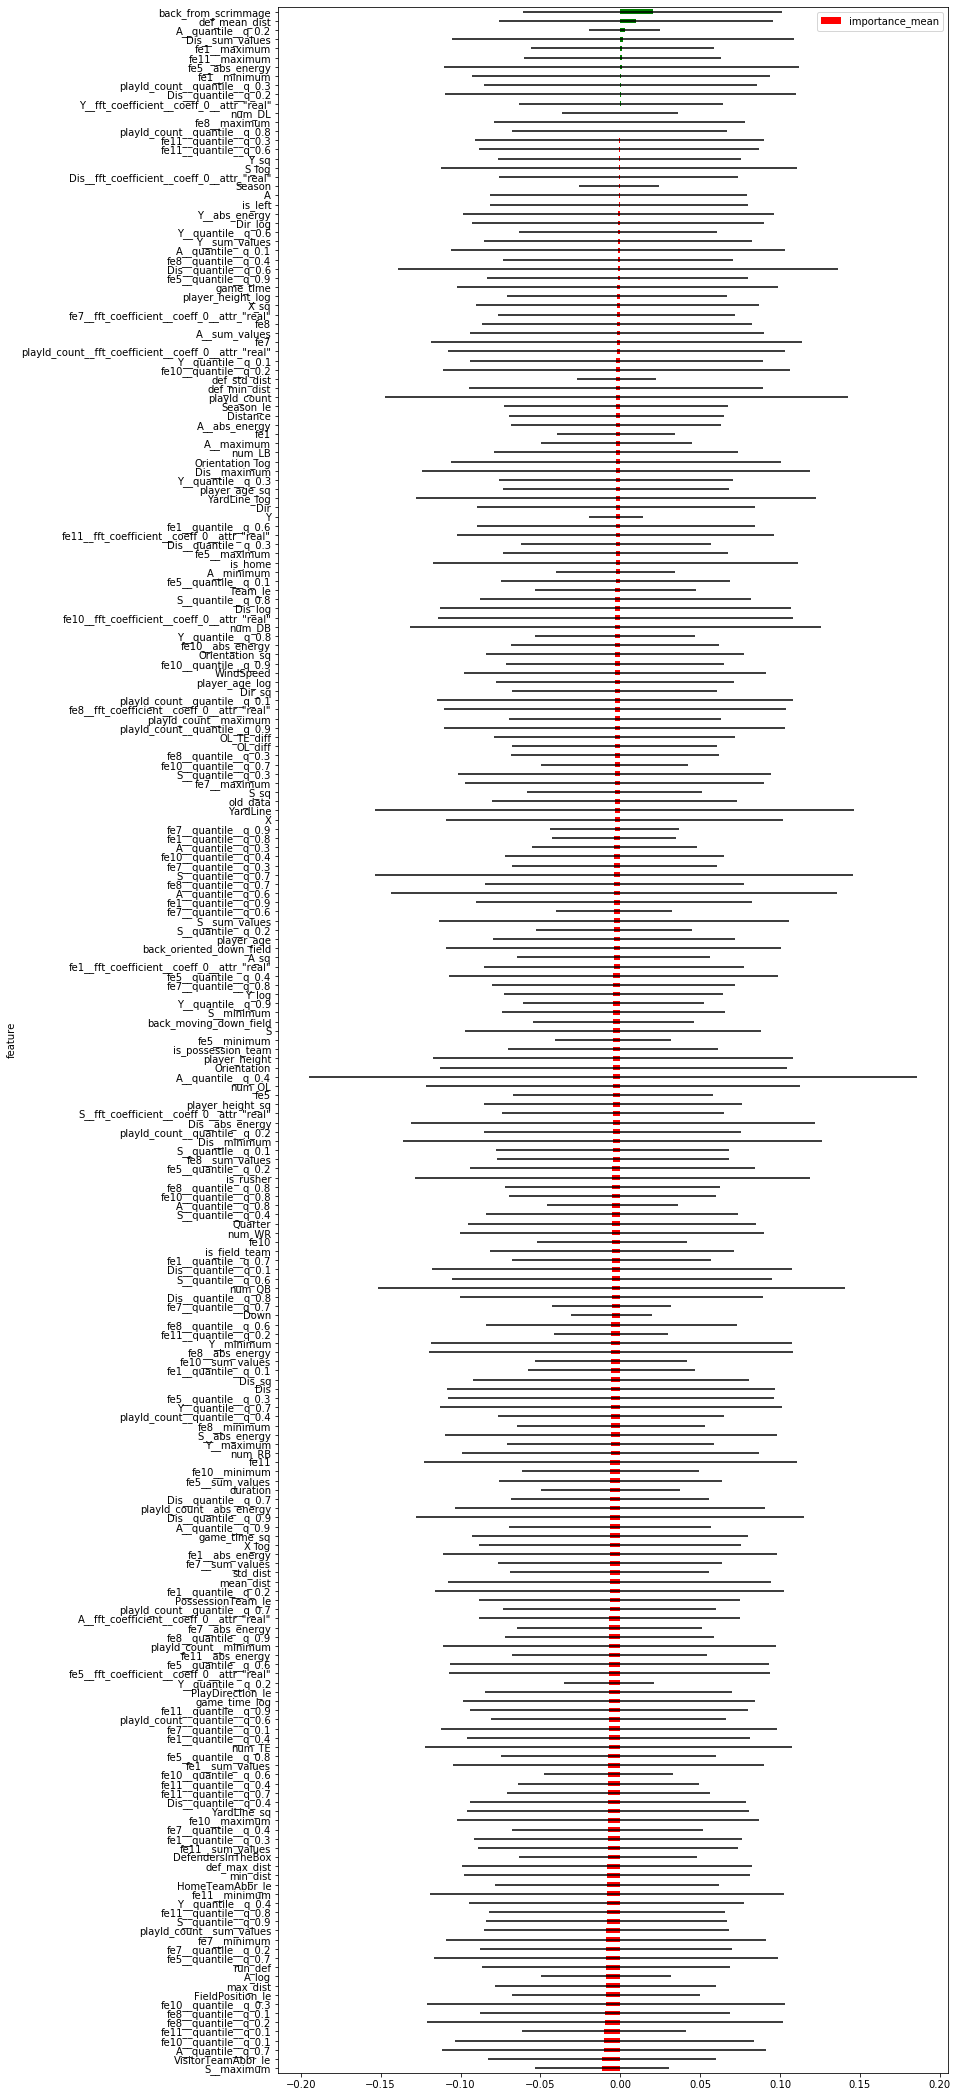

In [28]:
# Exibindo grafico com as features
plot_importance(importance_df, figsize=(12, 38))

In [33]:
best_features = importance_df.loc[importance_df['importance_mean'] != 0].feature

In [34]:
best_features

0                                    back_from_scrimmage
9                                          def_mean_dist
87                                    A__quantile__q_0.2
107                                      Dis__sum_values
162                                         fe1__maximum
149                                        fe11__maximum
173                                      fe5__abs_energy
163                                         fe1__minimum
218                        playId_count__quantile__q_0.3
100                                 Dis__quantile__q_0.2
122             Y__fft_coefficient__coeff_0__attr_"real"
25                                                num_DL
201                                         fe8__maximum
222                        playId_count__quantile__q_0.8
153                                fe11__quantile__q_0.3
155                                fe11__quantile__q_0.6
65                                                  Y_sq
55                             

## 4. Criar e avaliar alguns algoritmos de Machine Learning

In [35]:
# Criar um dataset somente com as colunas mais importantes conforme visto anteriormente
#new_X = X[['back_from_scrimmage','def_mean_dist','fe10','fe11','X_log','Dir','A_log','Down','def_min_dist','Quarter','is_field_team','num_WR','X_sq','is_possession_team','back_moving_down_field']]
new_X = X.loc[:,best_features]
target = X.Yards

y = np.zeros((target.shape[0], 199))
for idx, target in enumerate(list(target)):
    y[idx][99 + target] = 1

#new_X.drop(['Yards','GameId','PlayId'], axis=1, inplace=True) #,'TimeSnap','Team','PossessionTeam','HomeTeamAbbr','VisitorTeamAbbr','FieldPosition','PlayDirection','Season'], axis=1, inplace=True)
    
# Normalizando as variaveis do dataset de treino
scaler = StandardScaler()
new_X = scaler.fit_transform(new_X)

In [36]:
new_X.shape

(23171, 225)

## 4.3. Teste com Keras (New Struct)

In [37]:
class CRPSCallback(Callback):
    
    def __init__(self,validation, predict_batch_size=20, include_on_batch=False):
        super(CRPSCallback, self).__init__()
        self.validation = validation
        self.predict_batch_size = predict_batch_size
        self.include_on_batch = include_on_batch
        
        print('validation shape',len(self.validation))

    def on_batch_begin(self, batch, logs={}):
        pass

    def on_train_begin(self, logs={}):
        if not ('CRPS_score_val' in self.params['metrics']):
            self.params['metrics'].append('CRPS_score_val')

    def on_batch_end(self, batch, logs={}):
        if (self.include_on_batch):
            logs['CRPS_score_val'] = float('-inf')

    def on_epoch_end(self, epoch, logs={}):
        logs['CRPS_score_val'] = float('-inf')
            
        if (self.validation):
            X_valid, y_valid = self.validation[0], self.validation[1]
            y_pred = self.model.predict(X_valid)
            y_true = np.clip(np.cumsum(y_valid, axis=1), 0, 1)
            y_pred = np.clip(np.cumsum(y_pred, axis=1), 0, 1)
            val_s = ((y_true - y_pred) ** 2).sum(axis=1).sum(axis=0) / (199 * X_valid.shape[0])
            val_s = np.round(val_s, 6)
            logs['CRPS_score_val'] = val_s

In [38]:
def get_model(x_tr,y_tr,x_val,y_val):
    inp = Input(shape = (x_tr.shape[1],))
    x = Dense(1024, input_dim=X.shape[1], activation='relu')(inp)
    x = Dropout(0.5)(x)
    x = BatchNormalization()(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = BatchNormalization()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = BatchNormalization()(x)
    
    out = Dense(199, activation='softmax')(x)
    model = Model(inp,out)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=[])
    #add lookahead
#     lookahead = Lookahead(k=5, alpha=0.5) # Initialize Lookahead
#     lookahead.inject(model) # add into model

    
    es = EarlyStopping(monitor='CRPS_score_val', 
                       mode='min',
                       restore_best_weights=True, 
                       verbose=1, 
                       patience=10)

    mc = ModelCheckpoint('best_model.h5',monitor='CRPS_score_val',mode='min',
                                   save_best_only=True, verbose=1, save_weights_only=True)
    
    bsz = 1024
    steps = x_tr.shape[0]/bsz
    


    model.fit(x_tr, y_tr,callbacks=[CRPSCallback(validation = (x_val,y_val)),es,mc], epochs=100, batch_size=bsz,verbose=1)
    model.load_weights("best_model.h5")
    
    y_pred = model.predict(x_val)
    y_valid = y_val
    y_true = np.clip(np.cumsum(y_valid, axis=1), 0, 1)
    y_pred = np.clip(np.cumsum(y_pred, axis=1), 0, 1)
    val_s = ((y_true - y_pred) ** 2).sum(axis=1).sum(axis=0) / (199 * x_val.shape[0])
    crps = np.round(val_s, 6)

    return model,crps

In [39]:
losses = []
models = []
crps_csv = []

s_time = time.time()

#for k in range(2):
kfold = KFold(5, random_state = 42, shuffle = True)
for k_fold, (tr_inds, val_inds) in enumerate(kfold.split(y)):
    print("-----------")
    print("-----------")
    tr_x,tr_y = new_X[tr_inds],y[tr_inds]
    val_x,val_y = new_X[val_inds],y[val_inds]
    model,crps = get_model(tr_x,tr_y,val_x,val_y)
    models.append(model)
    print("the %d fold crps is %f"%((k_fold+1),crps))
    crps_csv.append(crps)

print("mean crps is %f"%np.mean(crps_csv))


def predict(x_te):
    model_num = len(models)
    for k,m in enumerate(models):
        if k==0:
            y_pred = m.predict(x_te,batch_size=1024)
        else:
            y_pred+=m.predict(x_te,batch_size=1024)
            
    y_pred = y_pred / model_num
    
    return y_pred

-----------
-----------
validation shape 2
Epoch 1/100
18536/18536 [==============================] - 2s 114us/step - loss: 5.6029

Epoch 00001: CRPS_score_val improved from inf to 0.07884, saving model to best_model.h5
Epoch 2/100
18536/18536 [==============================] - 1s 70us/step - loss: 5.1379

Epoch 00002: CRPS_score_val improved from 0.07884 to 0.07613, saving model to best_model.h5
Epoch 3/100
18536/18536 [==============================] - 1s 73us/step - loss: 4.7332

Epoch 00003: CRPS_score_val improved from 0.07613 to 0.06824, saving model to best_model.h5
Epoch 4/100
18536/18536 [==============================] - 1s 69us/step - loss: 4.3323

Epoch 00004: CRPS_score_val improved from 0.06824 to 0.05358, saving model to best_model.h5
Epoch 5/100
18536/18536 [==============================] - 1s 78us/step - loss: 3.9494

Epoch 00005: CRPS_score_val improved from 0.05358 to 0.03106, saving model to best_model.h5
Epoch 6/100
18536/18536 [==============================] - 1

18537/18537 [==============================] - 1s 71us/step - loss: 2.7155

Epoch 00022: CRPS_score_val did not improve from 0.01271
Epoch 23/100
18537/18537 [==============================] - 1s 74us/step - loss: 2.7140

Epoch 00023: CRPS_score_val did not improve from 0.01271
Epoch 24/100
18537/18537 [==============================] - 1s 76us/step - loss: 2.7041

Epoch 00024: CRPS_score_val did not improve from 0.01271
Epoch 25/100
18537/18537 [==============================] - 1s 76us/step - loss: 2.7044

Epoch 00025: CRPS_score_val improved from 0.01271 to 0.01270, saving model to best_model.h5
Epoch 26/100
18537/18537 [==============================] - 2s 82us/step - loss: 2.6954

Epoch 00026: CRPS_score_val improved from 0.01270 to 0.01268, saving model to best_model.h5
Epoch 27/100
18537/18537 [==============================] - 1s 75us/step - loss: 2.6929

Epoch 00027: CRPS_score_val did not improve from 0.01268
Epoch 28/100
18537/18537 [==============================] - 2s 93us

18537/18537 [==============================] - 1s 76us/step - loss: 2.7271

Epoch 00020: CRPS_score_val improved from 0.01270 to 0.01267, saving model to best_model.h5
Epoch 21/100
18537/18537 [==============================] - 2s 89us/step - loss: 2.7331

Epoch 00021: CRPS_score_val improved from 0.01267 to 0.01264, saving model to best_model.h5
Epoch 22/100
18537/18537 [==============================] - 1s 75us/step - loss: 2.7210

Epoch 00022: CRPS_score_val did not improve from 0.01264
Epoch 23/100
18537/18537 [==============================] - 1s 73us/step - loss: 2.7158

Epoch 00023: CRPS_score_val improved from 0.01264 to 0.01264, saving model to best_model.h5
Epoch 24/100
18537/18537 [==============================] - 1s 77us/step - loss: 2.7073

Epoch 00024: CRPS_score_val did not improve from 0.01264
Epoch 25/100
18537/18537 [==============================] - 1s 71us/step - loss: 2.7072

Epoch 00025: CRPS_score_val improved from 0.01264 to 0.01260, saving model to best_model.

the 4 fold crps is 0.012448
-----------
-----------
validation shape 2
Epoch 1/100
18537/18537 [==============================] - 2s 109us/step - loss: 5.5713

Epoch 00001: CRPS_score_val improved from inf to 0.07452, saving model to best_model.h5
Epoch 2/100
18537/18537 [==============================] - 1s 67us/step - loss: 5.0911

Epoch 00002: CRPS_score_val improved from 0.07452 to 0.07353, saving model to best_model.h5
Epoch 3/100
18537/18537 [==============================] - 1s 68us/step - loss: 4.6934

Epoch 00003: CRPS_score_val improved from 0.07353 to 0.06817, saving model to best_model.h5
Epoch 4/100
18537/18537 [==============================] - 1s 69us/step - loss: 4.3250

Epoch 00004: CRPS_score_val improved from 0.06817 to 0.05688, saving model to best_model.h5
Epoch 5/100
18537/18537 [==============================] - 1s 71us/step - loss: 3.9348

Epoch 00005: CRPS_score_val improved from 0.05688 to 0.03214, saving model to best_model.h5
Epoch 6/100
18537/18537 [=======

18537/18537 [==============================] - 1s 74us/step - loss: 2.6352

Epoch 00050: CRPS_score_val improved from 0.01294 to 0.01293, saving model to best_model.h5
Epoch 51/100
18537/18537 [==============================] - 1s 71us/step - loss: 2.6380

Epoch 00051: CRPS_score_val improved from 0.01293 to 0.01292, saving model to best_model.h5
Epoch 52/100
18537/18537 [==============================] - 1s 74us/step - loss: 2.6324

Epoch 00052: CRPS_score_val did not improve from 0.01292
Epoch 53/100
18537/18537 [==============================] - 1s 72us/step - loss: 2.6289

Epoch 00053: CRPS_score_val did not improve from 0.01292
Epoch 54/100
18537/18537 [==============================] - 1s 72us/step - loss: 2.6260

Epoch 00054: CRPS_score_val did not improve from 0.01292
Epoch 55/100
18537/18537 [==============================] - 1s 73us/step - loss: 2.6231

Epoch 00055: CRPS_score_val did not improve from 0.01292
Epoch 56/100
18537/18537 [==============================] - 1s 74us

In [40]:
print("mean crps is %f"%np.mean(crps_csv))

mean crps is 0.012652


## 5. Realizar a submissão para o Kaggle

In [ ]:
# Criando variavel para definir o modelo a ser submetido
modelo = 'NN_v2'

In [ ]:
from kaggle.competitions import nflrush
pd.options.mode.chained_assignment = None

env = nflrush.make_env()
iter_test = env.iter_test()

for (test_df, sample_prediction_df) in tqdm_notebook(iter_test):
    # Feature Engineering
    basetable = create_features_01(test_df, True)
    basetable = create_features_02(test_df)
    basetable = logs(basetable, log_features)
    basetable = squares(basetable, squared_features)
    basetable = basetable.fillna(0)
    
    # Remove algumas colunas
    basetable.drop(['TimeHandoff','PlayerBirthDate','GameClock','PlayerHeight','NflId','NflIdRusher'], axis=1, inplace=True)
    
    # Label Encoder para variaveis categoricas
    for cat in categoricals:
        le_dict[cat] = LabelEncoder()
        basetable[cat] = le_dict[cat].fit_transform(basetable[cat[:-3]].apply(str))  

    # Remove as colunas categoricas originais
    basetable.drop(['GameId','TimeSnap','Team','PossessionTeam','HomeTeamAbbr','VisitorTeamAbbr','FieldPosition','PlayDirection','Season'], axis=1, inplace=True)
    
    extract_test = basetable[['PlayId','X','Y','S','A','Dis','fe1','fe5','fe7','fe8','fe10','fe11']]
    
    extracted_feat_test = tsfresh.extract_features(extract_test,
                                                   column_id='PlayId',
                                                   column_sort='X',
                                                   #n_jobs = 2,
                                                   default_fc_parameters = params)
    
    extracted_feat_test = extracted_feat_test.fillna(0)
    extracted_feat_test = extracted_feat_test.loc[:, (extracted_feat_test != 0).any(axis=0)]
    extracted_feat_test = extracted_feat_test.reset_index()
    extracted_feat_test = extracted_feat_test.rename(columns={"id": "PlayId"})

    basetable = pd.merge(basetable, extracted_feat_test, on=['PlayId'], how='inner')
    
    basetable = basetable.loc[:,best_features]
    
    # Normalizacao
    scaled_basetable = scaler.transform(basetable)

    if modelo == 'RF':    
        # Realiza as previsões para cada Kfold e grava a media
        y_pred = np.mean([model.predict(scaled_basetable) for model in modelsRF],axis=0)
    
    elif modelo == 'NN':
        # Realiza as previsões de acordo com o modelo Keras
        y_pred = model_nn.predict(scaled_basetable) 
    
    elif modelo == 'NN_v2':
        # Realiza as previsões de acordo com o modelo Keras modificado
        y_pred = predict(scaled_basetable)

    y_pred = np.clip(np.cumsum(y_pred, axis=1), 0, 1).tolist()[0]
    
    preds_df = pd.DataFrame(data=[y_pred], columns=sample_prediction_df.columns)
    env.predict(preds_df)
    
env.write_submission_file()